In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import mne
from mne import Epochs, pick_types, annotations_from_events, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP, SPoC
from mne.viz import plot_events, plot_montage
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs, corrmap, Xdawn

mne.set_log_level("CRITICAL")

In [4]:
tmin, tmax = -1.0, 4.0
subject = 1
experiment = {
    "runs": [3, 7, 11],
    "mapping": {0: "rest", 1: "left fist", 2: "right fist"},
}
event_id = dict(T0=0, T1=1, T2=2)
drop_channels = False

## Data

In [5]:

raw_fnames = [f"dataset/S{subject:03d}/S{subject:03d}R{run:02d}.edf" for run in experiment["runs"]]
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
events, _ = events_from_annotations(raw, event_id=event_id)
raw_annotations_from_events = annotations_from_events(
    events=events, event_desc=experiment["mapping"], sfreq=raw.info["sfreq"]
)
raw.set_annotations(raw_annotations_from_events)
eegbci.standardize(raw)  # set channel names
raw.info

<Info | 7 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
>

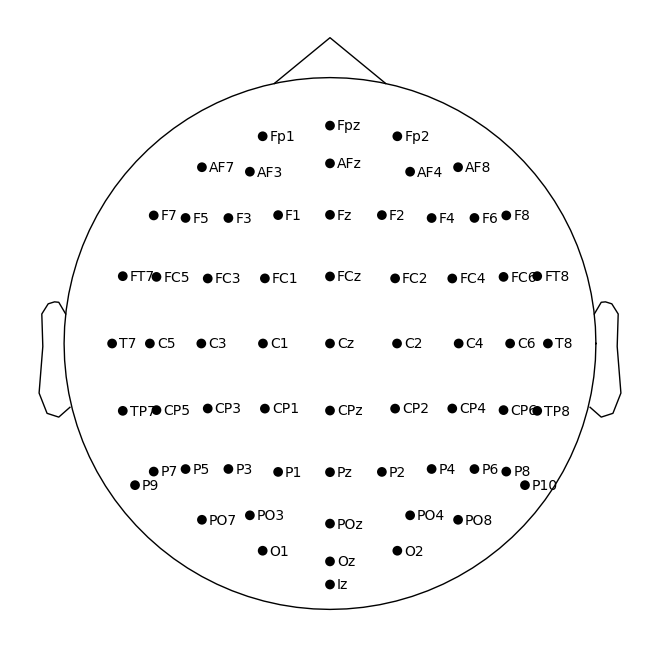

In [6]:
montage = make_standard_montage("biosemi64")
raw.set_montage(montage, on_missing='ignore')
montage.plot()
plt.show()

In [7]:
# Select channels
# See https://arxiv.org/pdf/1312.2877.pdf -- page 3
channels = raw.info["ch_names"]
print(channels)

['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FT8', 'T7', 'T8', 'T9', 'T10', 'TP7', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'Iz']


## Visualize raw data

In [8]:
raw.plot(scalings=dict(eeg=200e-6))
plt.show()

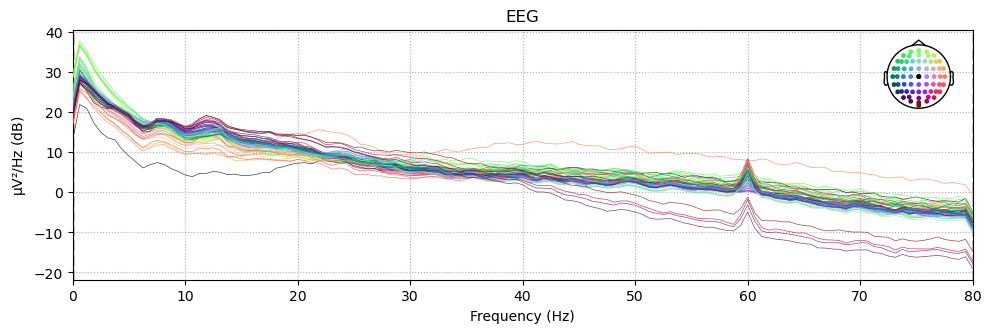

In [9]:
raw.compute_psd().plot()
plt.show()

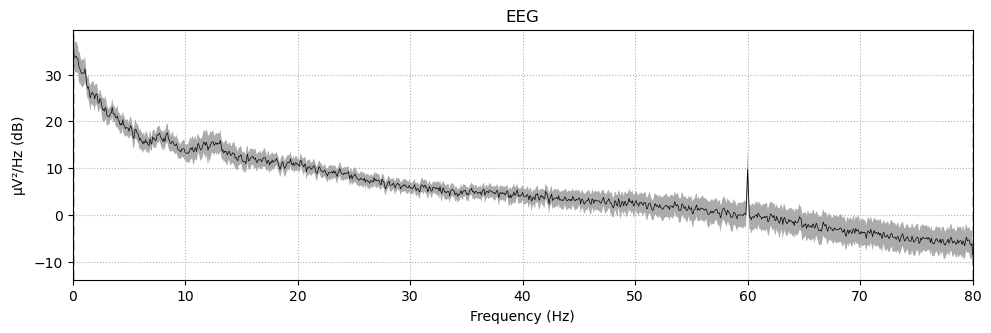

In [10]:
raw.plot_psd(average=True)
plt.show()

## Filter

In [11]:
# Select channels
# See https://arxiv.org/pdf/1312.2877.pdf -- page 3
if drop_channels:
    channels = raw.info["ch_names"]
    print(channels, len(channels))
    good_channels = [
        "FC3",
        "FC1",
        "FCz",
        "FC2",
        "FC4",
        "C3",
        "C1",
        "Cz",
        "C2",
        "C4",
        "CP3",
        "CP1",
        "CPz",
        "CP2",
        "CP4",
    ]
    bad_channels = [x for x in channels if x not in good_channels]
    raw.drop_channels(bad_channels)

In [12]:
# Apply band-pass filter
raw.notch_filter(60, method="iir")
raw.filter(7, 32.0, fir_design="firwin", skip_by_annotation="edge")
raw.plot(scalings=dict(eeg=200e-6))
plt.show()

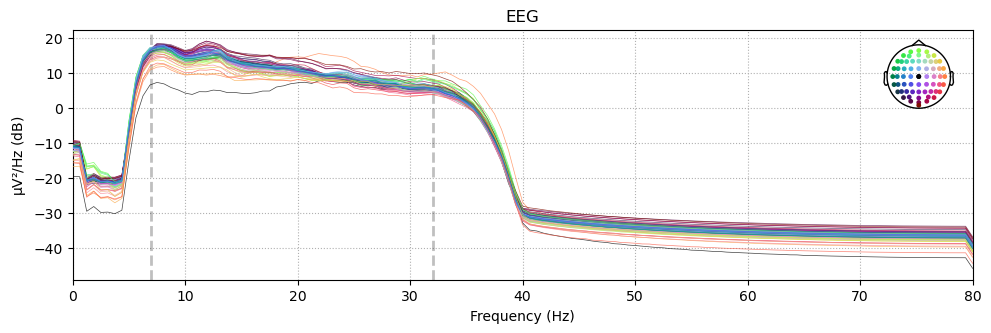

In [13]:
raw.compute_psd().plot()
plt.show()

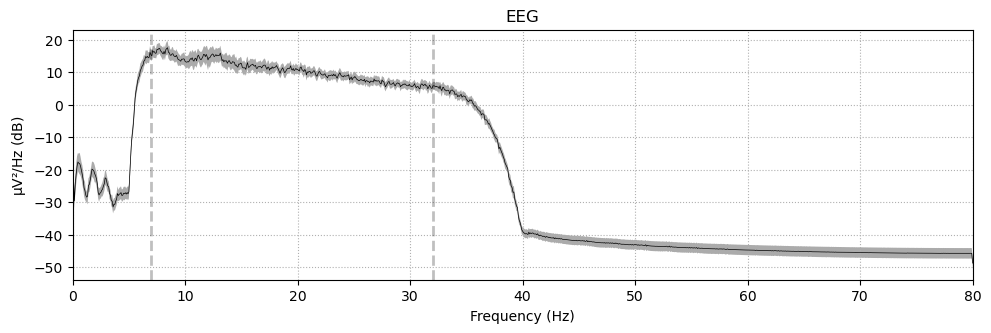

In [14]:
raw.plot_psd(average=True)
plt.show()

## Events

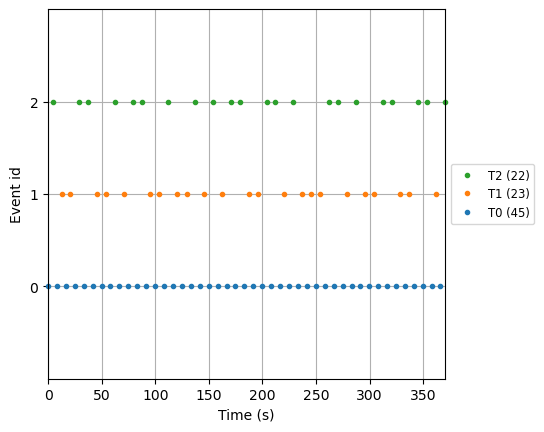

In [15]:
fig = plot_events(events, sfreq=raw.info["sfreq"], first_samp=raw.first_samp, event_id=event_id)
fig.subplots_adjust(right=0.7)

In [16]:
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks, baseline=None, preload=True)
epochs.events[:, -1]

array([2, 0, 1, 0, 1, 0, 2, 0, 2, 0, 1, 0, 1, 0, 2, 0, 1, 0, 2, 0, 2, 0,
       1, 0, 1, 0, 2, 0, 1, 0, 1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 0, 2, 0,
       1, 0, 1, 0, 2, 0, 2, 0, 1, 0, 2, 0, 1, 0, 1, 0, 1, 0, 2, 0, 2, 0,
       1, 0, 2, 0, 1, 0, 1, 0, 2, 0, 2, 0, 1, 0, 1, 0, 2, 0, 2, 0, 1, 0,
       2])